In [6]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import os
from PIL import Image
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Preprocess

In [24]:
# Paths
mario_path = 'data/mario/'
luigi_path = 'data/luigi/'

# Load and preprocess images
img_size = (128, 128)

def process_images(image_path):
    images = [Image.open(image_path + img).convert('RGB') for img in os.listdir(image_path)]
    images_resized = [img.resize(img_size) for img in images]
    images_array = [np.array(img)/255.0 for img in images_resized]
    return images_array

mario_arrays = process_images(mario_path)
luigi_arrays = process_images(luigi_path)

# Check image dimensions
for img_array in mario_arrays + luigi_arrays:
    assert img_array.shape == (128, 128, 3), f"Unexpected shape: {img_array.shape}"

mario_labels = np.zeros(len(mario_arrays))
luigi_labels = np.ones(len(luigi_arrays))

X = np.array(mario_arrays + luigi_arrays)
y = np.concatenate([mario_labels, luigi_labels])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)


In [25]:
# check shuffle
print(y_train)
print(y_test)

[0. 0. 0. ... 1. 0. 1.]
[0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 1.

# Explore the dataset and display a few images


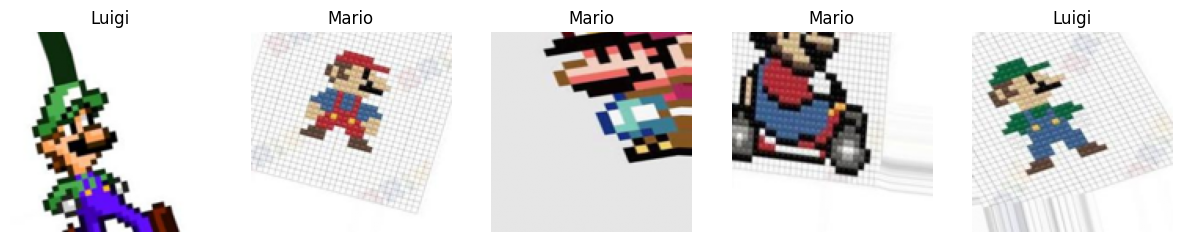

In [26]:
import matplotlib.pyplot as plt
import random

# Create labels for Mario and Luigi images
mario_labels = ['Mario'] * len(mario_arrays)
luigi_labels = ['Luigi'] * len(luigi_arrays)

# Combine all image arrays and labels
all_images = mario_arrays + luigi_arrays
all_labels = mario_labels + luigi_labels

# Randomly select a few images and their labels
num_images_to_display = 5
selected_indices = random.sample(range(len(all_images)), num_images_to_display)
selected_images = [all_images[i] for i in selected_indices]
selected_labels = [all_labels[i] for i in selected_indices]

# Display the images with their labels
plt.figure(figsize=(15, 5))
for idx, (img_array, label) in enumerate(zip(selected_images, selected_labels), start=1):
    plt.subplot(1, num_images_to_display, idx)
    plt.imshow(img_array)
    plt.title(label)
    plt.axis('off')
plt.show()




# Build the CNN

In [5]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),  # Increased dropout
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),  # Increased dropout
    
    Flatten(),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), name='embs'),  # L2 regularization and reduced neurons
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

#using early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

When using early stopping in Keras, the model's weights are automatically reverted to those from the epoch with the best monitored metric (e.g., validation loss) if you set the `restore_best_weights` parameter to `True`.

With the above settings:

- `monitor='val_loss'`: This means the early stopping mechanism is monitoring the validation loss.
- `patience=10`: This means training will continue for 10 epochs even after the monitored metric has stopped improving. If there's no improvement after these additional epochs, training will stop.
- `restore_best_weights=True`: This ensures that once training is halted, the model's weights are rolled back to the weights from the epoch with the best (lowest) `val_loss`.

By using the `restore_best_weights=True` option, you don't need to manually track and restore the best model from the `history` object. The early stopping callback takes care of it for you. After training is complete, the model will already be set to its best weights, and you can use it for predictions, further training, or saving.

In [6]:
#   model fit early stopping
# model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stop])
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/50
51/51 [==============================] - 13s 227ms/step - loss: 1.8623 - accuracy: 0.8914 - val_loss: 1.7897 - val_accuracy: 0.8695
Epoch 2/50
51/51 [==============================] - 10s 196ms/step - loss: 0.9903 - accuracy: 0.9766 - val_loss: 2.9892 - val_accuracy: 0.5443
Epoch 3/50
51/51 [==============================] - 11s 211ms/step - loss: 0.5944 - accuracy: 0.9741 - val_loss: 4.6867 - val_accuracy: 0.5443
Epoch 4/50
51/51 [==============================] - 11s 222ms/step - loss: 0.4127 - accuracy: 0.9821 - val_loss: 4.7106 - val_accuracy: 0.5443
Epoch 5/50
51/51 [==============================] - 11s 222ms/step - loss: 0.3260 - accuracy: 0.9889 - val_loss: 7.6713 - val_accuracy: 0.5443
Epoch 6/50
51/51 [==============================] - 11s 216ms/step - loss: 0.3338 - accuracy: 0.9895 - val_loss: 4.2476 - val_accuracy: 0.5443
Epoch 7/50
51/51 [==============================] - 12s 232ms/step - loss: 0.3211 - accuracy: 0.9907 - val_loss: 3.3740 - val_accuracy: 0.5714

When training a model, these metrics provide insights into the model's performance during training and validation. Let's break down each term:

1. **loss**: This is the value of the loss function that the model is trying to minimize during training. A lower loss indicates that the model's predictions are closer to the true labels of the training data. In this case, the value `0.0263` suggests that the model is performing well on the training data.

2. **accuracy**: This metric measures the proportion of correctly classified samples out of the total samples in the training set. The value `0.9941` (or 99.41%) indicates that the model is correctly classifying approximately 99.41% of the training samples.

3. **val_loss**: This is the value of the loss function for the validation set. The validation set is a subset of your data that the model hasn't seen during training. It's used to evaluate the model's performance on unseen data. A high validation loss (e.g., `2.2401` in this case) compared to the training loss might indicate that the model is overfitting to the training data.

4. **val_accuracy**: This metric measures the proportion of correctly classified samples in the validation set. The value `0.5233` (or 52.33%) indicates that the model correctly classifies approximately 52.33% of the samples in the validation set.

In summary, the provided metrics suggest that:
- If the **difference between the accuraccy and the val_accuraccy** is very big then we have overfitting.
- The **early_stop** stops the training when the validation accuraccy stops improving after trying `patience` epochs. After this, we can recover the best model thanks to history
- **Having more data** has a huge difference in model accuraccy


In [7]:
model.save('model/mario_luigi_model.h5')

# Confusion matrix

13/13 [==============================] - 1s 50ms/step


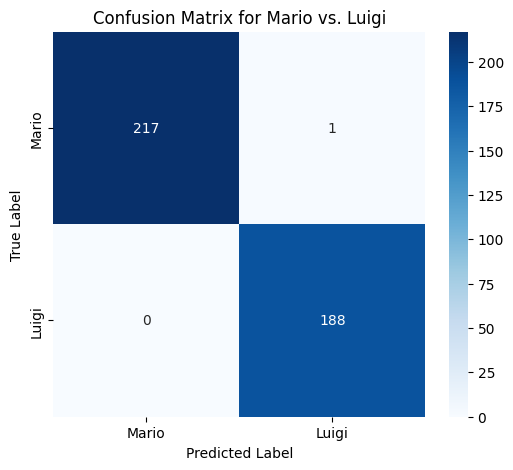

In [9]:
model = tf.keras.models.load_model('model/mario_luigi_model.h5')

# Predict labels for the test set
y_pred_probs_binary = model.predict(X_test)  # Assuming 'model' was the binary classifier
y_pred_binary = (y_pred_probs_binary > 0.5).astype(int).flatten()

# Compute the confusion matrix
conf_mat_binary = confusion_matrix(y_test, y_pred_binary)  # Note: y_test is directly used here

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Mario', 'Luigi'], 
            yticklabels=['Mario', 'Luigi'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Mario vs. Luigi')
plt.show()


# Predict images

1/1 [==============================] - 0s 54ms/step


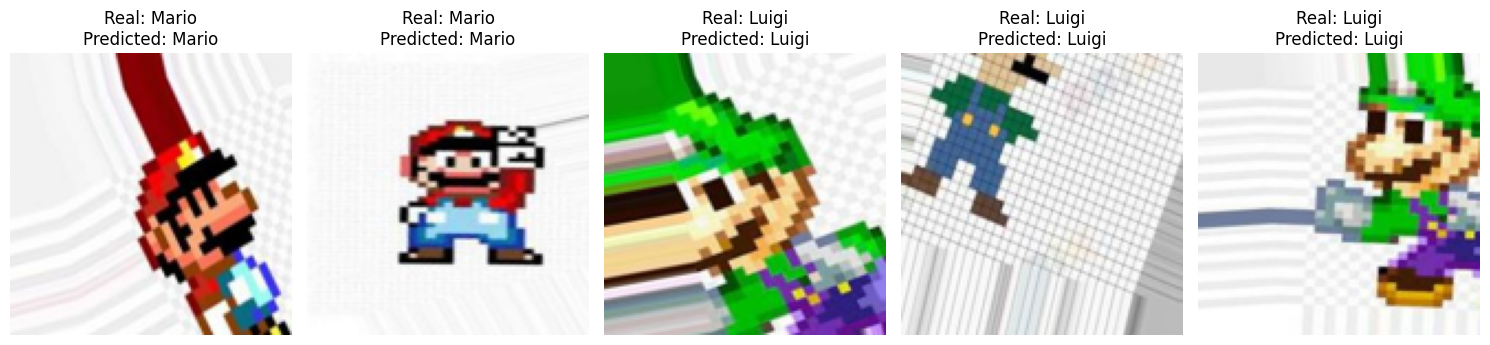

In [9]:
# Predict labels for the selected images
predicted_probs = model.predict(np.array(selected_images))
predicted_labels = ['Mario' if prob < 0.5 else 'Luigi' for prob in predicted_probs]

# Display the images with real and predicted labels
plt.figure(figsize=(15, 5))
for idx, (img_array, real_label, pred_label) in enumerate(zip(selected_images, selected_labels, predicted_labels), start=1):
    plt.subplot(1, num_images_to_display, idx)
    plt.imshow(img_array)
    plt.title(f"Real: {real_label}\nPredicted: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()



# Extract embeddings from the trained model

You typically take the output from one of the intermediate layers. These embeddings can be used for various purposes, such as visualization, clustering, or as input to another model.
Let's assume you want to extract embeddings from the layer just before the final classification layer. In the CNN model we discussed earlier, this would be the dense layer with 128 units (named 'dense_128' for this example).

In [27]:
from tensorflow.keras.models import Model

# 'model' is your trained CNN model
# Using the Keras Functional API or the Model class, you can define a new model that has the same input as your original model but outputs from the desired layer.
# I named the layer `embsp  when creating the model
embedding_model = Model(inputs=model.input, outputs=model.get_layer('embs').output)

64/64 [==============================] - 4s 56ms/step


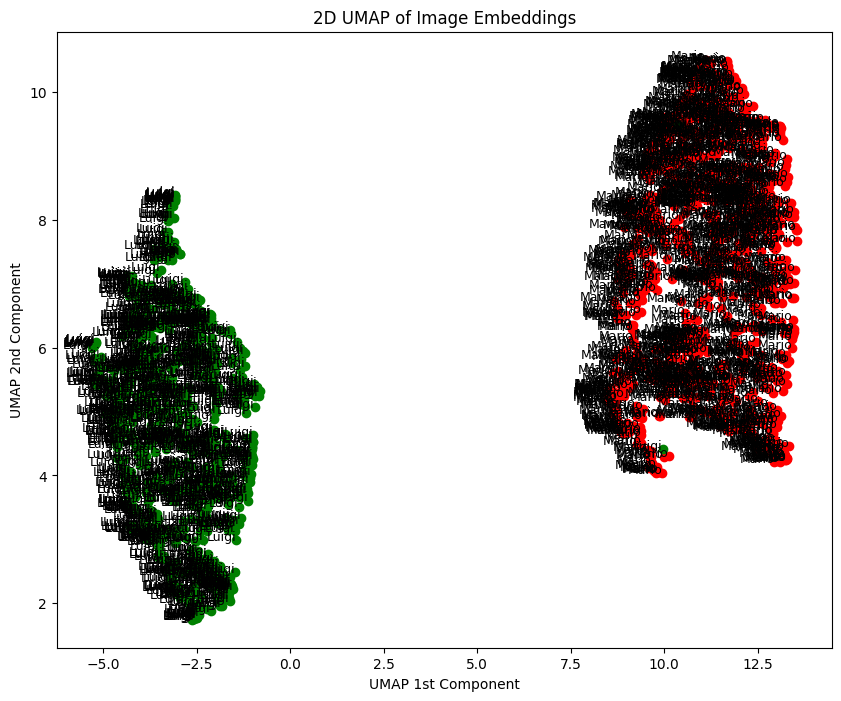

In [28]:
import umap
import matplotlib.pyplot as plt

# 1. Extract embeddings for all images using the embedding_model
all_images_array = np.array(all_images)
embeddings = embedding_model.predict(all_images_array)

# 2. Reduce dimensionality using UMAP
reducer = umap.UMAP(random_state=1)
embeddings_2d = reducer.fit_transform(embeddings)

# 3. Plot the 2D representations with labels
plt.figure(figsize=(10, 8))

for i, label in enumerate(all_labels):
    color = 'red' if label == 'Mario' else 'green'
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=color)
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], label, fontsize=9, ha='right')

plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.title('2D UMAP of Image Embeddings')
plt.show()



# Adding Toad embeddings into the UMAP map to evaluate if toad falls closer to luigi or to mario in this model

13/13 [==============================] - 1s 51ms/step


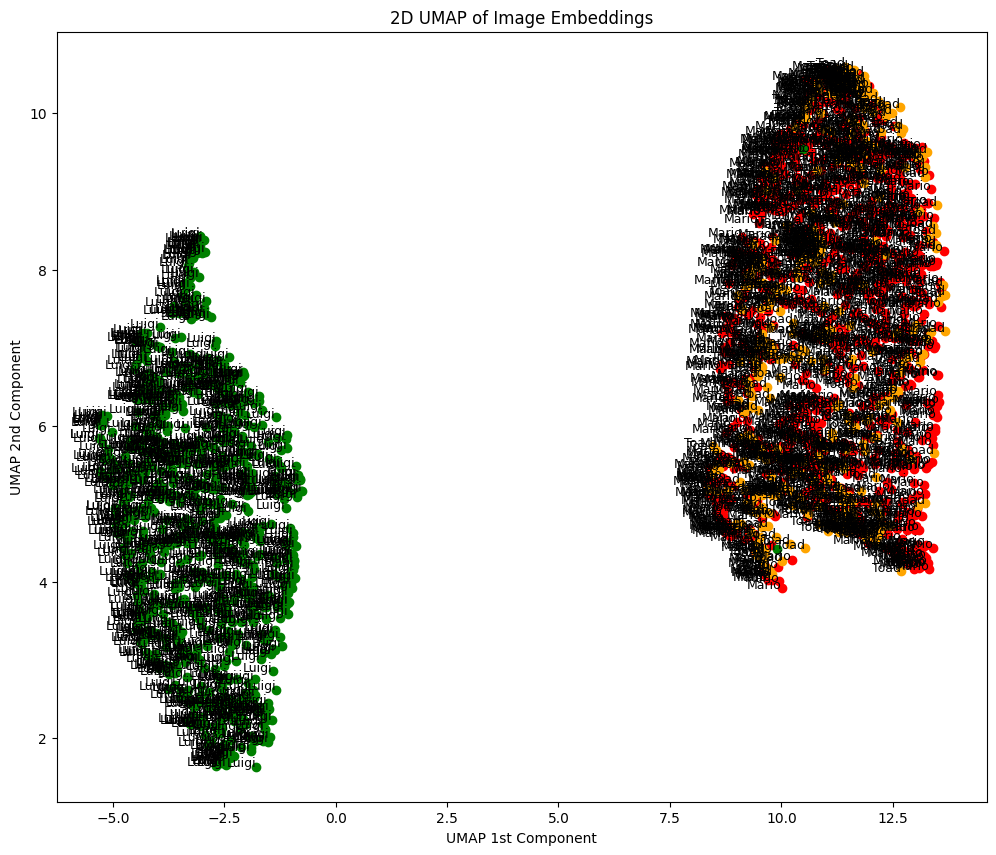

In [12]:
# 1. Load and preprocess 'toad' images
toad_path = 'data/toad/'

toad_images = [Image.open(toad_path + img).convert('RGB').resize(img_size) for img in os.listdir(toad_path)]
toad_arrays = [np.array(img)/255.0 for img in toad_images]

# 2. Extract embeddings for 'toad' images using the embedding_model
toad_embeddings = embedding_model.predict(np.array(toad_arrays))

# 3. Combine all embeddings and labels
all_embeddings = np.vstack([embeddings, toad_embeddings])
all_labels_combined = all_labels + ['Toad'] * len(toad_arrays)

# 4. Reduce dimensionality using UMAP
all_embeddings_2d = reducer.transform(all_embeddings)

# 5. Plot the 2D representations with labels
plt.figure(figsize=(12, 10))

colors = {'Mario': 'red', 'Luigi': 'green', 'Toad': 'orange'}

for i, label in enumerate(all_labels_combined):
    plt.scatter(all_embeddings_2d[i, 0], all_embeddings_2d[i, 1], color=colors[label])
    plt.text(all_embeddings_2d[i, 0], all_embeddings_2d[i, 1], label, fontsize=9, ha='right')

plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.title('2D UMAP of Image Embeddings')
plt.show()


# Create a 3D u-map with mario and luigi


64/64 [==============================] - 3s 44ms/step


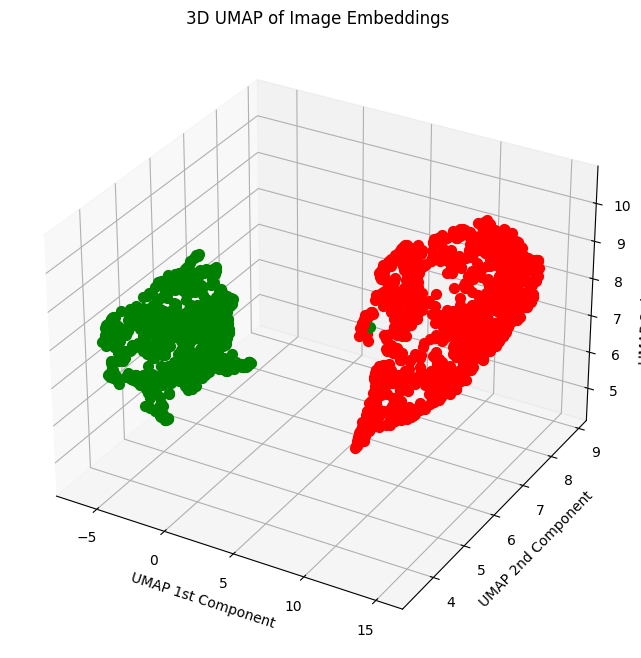

In [29]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Extract embeddings for all images using the embedding_model
all_images_array = np.array(all_images)
embeddings = embedding_model.predict(all_images_array)

# 2. Reduce dimensionality to 3D using UMAP
reducer = umap.UMAP(n_components=3, random_state=1)
embeddings_3d = reducer.fit_transform(embeddings)

# 3. Plot the 3D representations with labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(all_labels):
    color = 'red' if label == 'Mario' else 'green' if label == 'Luigi' else 'orange'
    ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], color=color, s=50)
    # If you want to display the names of the embeddings, uncomment the next line.
    # ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], label, fontsize=9)

ax.set_xlabel('UMAP 1st Component')
ax.set_ylabel('UMAP 2nd Component')
ax.set_zlabel('UMAP 3rd Component')
ax.set_title('3D UMAP of Image Embeddings')
plt.show()
